Defina o backend do matplotlib para que os valores possam ser salvos em segundo plano

In [1]:
import matplotlib

Importe os pacotes necessários

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from pyimagesearch.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os
import livelossplot

Using TensorFlow backend.


Inicializa o número de épocas para treinamento, taxa de aprendizado inicial, batch size e dimensões da imagem


In [10]:
dataset = 'dataset'

EPOCHS = 3
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)
modelname = 'aedes'
label = 'lb.pickle'

Inicializa os dados e os rótulos

In [11]:
data = []
labels = []

Pega os caminhos das imagens e embaralha aleatoriamente

In [12]:
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


Loop sobre as imagens de entrada

In [13]:
for imagePath in imagePaths:
	# carrega a imagem, pré-process e armazena na lista de dados
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = img_to_array(image)
	data.append(image)
 
	# extraia o rótulo da classe do caminho da imagem e atualize a lista de rótulos
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

Escalona as intensidades dos pixel para o intervalo [0, 1]

In [14]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
	data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 208.22MB


Transformar os rótulos em binários

In [15]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

Particiona os dados em divisões de treinamento e teste usando 80% dos dados para treinamento e os 20% restantes para testes


In [16]:
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)

construir o gerador de imagem para aumento de dados

In [17]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

Inicializa a model

In [18]:
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


Treina a rede

In [19]:
plot_losses = livelossplot.PlotLossesKeras()

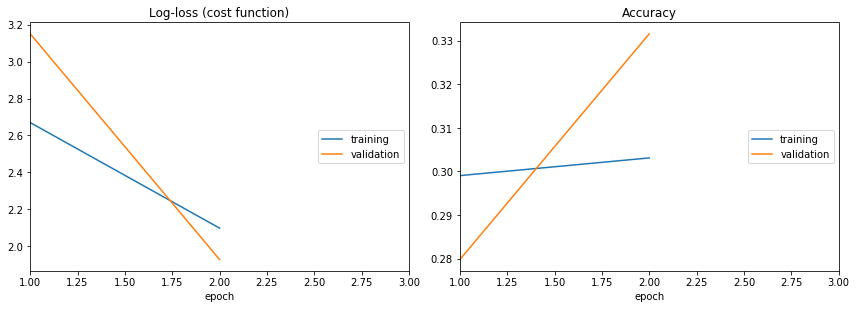

In [ ]:
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
    callbacks=[plot_losses],
    verbose=0)

Salva a rede no disco

In [ ]:
print("[INFO] serializing network...")
model.save(modelname)

Salva os rótulos binários no disco

In [ ]:
print("[INFO] serializing label binarizer...")
f = open(label, "wb")
f.write(pickle.dumps(lb))
f.close()

Traça a perda e a precisão do treinamento